In [24]:
# This works for bootstrapping!!! With constant AND trend :)

% cd C:\Users\wolfg\Desktop\Uni\UCL\Macroeconomic Policy

import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile

from scipy import stats
#from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR, SVAR
# from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.base.datetools import dates_from_str
#import statsmodels.tsa.tsatools as tsa
#from statsmodels.tools.numdiff import (approx_hess, approx_fprime)
#import numpy.linalg as npl

% matplotlib inline
from pylab import rcParams
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt

df = pd.read_excel('Exer1new.xls', sheet_name='data')

# Get per capita variables

df['pop'] = pd.to_numeric(df['pop'], errors='coerce')
df.dropna(inplace = True)
df['gdp'] = np.log(df['gdp']/df['pop'])
df['cons'] = np.log(df['cons']/df['pop'])
df['gov'] = np.log(df['gov']/df['pop'])
del df['consndur']
del df['defense']
del df['pop']
df['date'] = df['date'].astype(str)

df[['year','quarter']] = df['date'].str.split('.',expand=True)
df['quarter'] = df['quarter'].apply(lambda x: '1' if x == '0' else ('2' if x == '25' else ('3' if x == '5' else '4')))
dates = df[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)
df.index = pd.DatetimeIndex(quarterly, freq = 'Q')
df_original = df.copy()

del df['year']
del df['quarter']
del df['date']


lags = 4
columns = ['gdp', 'cons', 'gov']
df.head()

C:\Users\wolfg\Desktop\Uni\UCL\Macroeconomic Policy


,gdp,cons,gov
1948-03-31,-3.944602,-4.425687,-5.348727
1948-06-30,-3.930638,-4.416271,-5.317915
1948-09-30,-3.927961,-4.417697,-5.301045
1948-12-31,-3.928605,-4.411462,-5.267008
1949-03-31,-3.944263,-4.411745,-5.241587


In [25]:
def produce_lags(data, columns, lags):

    covariates = []

    for col in columns:
    
        for lag in range(1,lags+1):
        
            data[col + "_" + str(lag)] = data[col].shift(periods = lag)
        
            covariates.append(col + "_" + str(lag))

    df = data.dropna()
                 
    return df, covariates

def OLS_reg(data, x, y):
    
    # here we include a constant and a trend variable to achieve trend stationarity
    # can be implemented such that it needs to be specified
    
    constant = np.ones(len(data))
    trend = np.array(range(1, len(data)+1))
    ct = np.stack((constant, trend), axis=1)
    x = np.array(data[x])
    x = np.append(ct, x, axis = 1)
    y = np.array(data[y])
    xTx = np.matmul(x.T,x)
    xTy = np.matmul(x.T,y)
    xTx_inv = np.linalg.inv(xTx)
    beta = np.matmul(xTx_inv, xTy)
    residuals = y - np.matmul(x, beta)
    
    return beta, residuals

def run_VAR(data, covariates, columns):

    reduced_form_coefficients = []
    reduced_form_residuals = []

    for i in columns:
    
        [beta, res] = OLS_reg(data, covariates, i)
    
        reduced_form_coefficients.append(beta)
        reduced_form_residuals.append(res)
    
    reduced_form_coefficients = np.vstack((reduced_form_coefficients))
    reduced_form_residuals = np.vstack((reduced_form_residuals))
    
    return reduced_form_coefficients, reduced_form_residuals

def tidy_IRF(columns, reduced_form_coefficients, lags):
    
    merged_coefficients = np.array(())

    for i in range(len(columns)):
    
        merged_coefficients = np.concatenate((merged_coefficients, reduced_form_coefficients[i][2:]))
    
    # Note here: the [2:] corresponds to the exclusion of the first two coefficients, i.e. constant and trend since they
    # don't matter for the computation of IRFs

    merged_coefficients = np.reshape(merged_coefficients,(len(columns)**2,lags)).T

    empty_list = []

    for i in range(len(merged_coefficients)):
    
        obj = np.reshape(merged_coefficients[i], (len(columns),len(columns)))
    
        empty_list.append(obj)
    
    empty_array = np.array(())

    for i in range(len(columns)):
    
        for j in range(len(empty_list)):
        
            obj = empty_list[j][i]
        
            empty_array = np.append(empty_array, obj)
        
    empty_array = np.reshape(empty_array, (len(columns),len(columns)*lags))
    
    return empty_array

def create_companion(columns, lags, empty_array):

    Companion = np.zeros((lags*len(columns), lags*len(columns)))

    for i in range(lags*len(columns)):
    
        if i < len(columns):
    
            Companion[(i)] = empty_array[(i)]
    
        if i >= len(columns):
        
            Companion[(i,i-len(columns))] = 1
            
    return Companion

def create_IRF(impulse_var, columns_input, A0_inv, forecast_horizon, Companion):

    #impulse_var = 'gov'
    impulse_index = columns_input.index(impulse_var)
    shock_vector = np.zeros((len(columns_input), 1))
    shock_vector[(impulse_index)] = 1
    shock_vector = np.matmul(A0_inv, shock_vector)

    #forecast_horizon = 20

    IRF = np.zeros((forecast_horizon, len(columns_input)))

    for h in range(forecast_horizon):
    
        if h == 0:
        
            IRF[(h)] = shock_vector.T
        
        elif h > 0:
        
            Companion_comp = np.linalg.matrix_power(Companion,h)
            Companion_selection = Companion_comp[0:len(columns_input), 0:len(columns_input)]
            IRF_calc = np.matmul(Companion_selection, A0_inv).T[impulse_index]
            IRF[(h)] = IRF_calc
            
    return IRF

def create_IRF_plot(IRF, columns, forecast_horizon, impulse_var):
    
    rcParams['figure.figsize'] = 15, 5

    IRF_df = pd.DataFrame(IRF)
    IRF_df.columns = columns
    # rcParams['figure.figsize'] = 15, 5
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

    f, axarr = plt.subplots(1,len(columns), sharex=False, sharey=False)
    f.suptitle('Impulse Response Functions')
    x = range(forecast_horizon)

    for color, i, idx in zip(colors, columns, range(len(columns))):
    
        axarr[idx].plot(x, IRF_df[i], color = color)
        axarr[idx].set(xlabel='t', ylabel='Impulse Response to ' + impulse_var + ' shock')
        axarr[idx].legend()
    
        if (sum(IRF_df[i] > 0) > 0 and sum(IRF_df[i] < 0) > 0):
        
            axarr[idx].axhline(linewidth=1, color='r', linestyle = '--')
        
    f.subplots_adjust(left = None, right = None, hspace=0, wspace = 0.3)
    
def get_A0(data, covariates, reduced_form_residuals):
    
    covariates.append('gov_res')
    data['gov_res'] = reduced_form_residuals[2]
    a0_gov_gdp = OLS_reg(data, covariates, 'gdp')[0][-1]*-1
    a0_gov_cons = OLS_reg(data, covariates, 'cons')[0][-1]*-1
    a0_gov_gov = 1

    A0 = np.array([[1, 0, a0_gov_gdp],
              [0, 1, a0_gov_cons],
              [0, 0, a0_gov_gov]])

    A0_inv = np.linalg.inv(A0)
    
    covariates = covariates[:-1]
    del data['gov_res']
    
    return A0, A0_inv, covariates, data

def get_BS_TS(coefs, df_orig, lags, columns, residuals, ct, test, sig_u = None, burn = 100):
    
    if test == True:
    
        nobs = len(df_orig)
        
        initial_values = df_orig.iloc[:lags, 1:len(columns)+1].values
        
        steps = nobs + burn

        p, k, k = coefs.shape
        if sig_u is None:
            sig_u = np.eye(k)

        #np.random.seed(1)   
        
        #rs = np.random.RandomState(seed=1)
        #rmvnorm = rs.multivariate_normal
        
        #ugen = rmvnorm(np.zeros(len(sig_u)), sig_u, steps)
    
        ugen = residuals[np.random.randint(residuals.shape[0], size=steps), :]
    
        result = np.zeros((steps, k))
        if initial_values is not None:
            result[:p] = initial_values
            result[p:] += ct[0]
            result[p:] += ugen[p:]
        else:
            result[p:] = ugen[p:]
    # add in AR terms
        for t in range(p, steps):
            
            ygen = result[t]
    
            for j in range(p):
        
                ygen += np.dot(coefs[j], result[t-j-1])
        
            #ygen += ct[1]*(t-1) + ct[0]
            
    # for test purposes only, test case if output from own methods is inputted
            
    if test == False:
        
        splitted_array = np.split(coefs.T, lags)

        coefs = np.array([])
        
        nobs = len(df_orig)
        
        initial_values = df_orig.iloc[:lags, 1:len(columns)+1].values

        for i in splitted_array:
        
            coefs = np.append(coefs, i.T)

        coefs = coefs.reshape(lags,len(columns),len(columns))
        
        steps = nobs + burn

        p, k, k = coefs.shape
    
        if sig_u is None:

            sig_u = np.eye(k)

        #np.random.seed(1)

        ugen = residuals.T[np.random.randint(residuals.T.shape[0], size=steps + lags), :]
        
        ugen[p:] = stats.zscore(ugen[p:]) # standardizing residuals

        result = np.zeros((steps + lags, k))

        if initial_values is not None:
            
            result[:p] = initial_values    
            result[p:] = ugen[p:]
        else:
            result[p:] = ugen[p:]

        for t in range(p, (steps + lags)):
            
            ygen = result[t]

            for j in range(p):
                
                ygen += np.dot(coefs[j], result[t-j-1])
    
            ygen += ct.T[1]*(t-1) + ct.T[0] # adding intercept and slope
        
    result_df = pd.DataFrame(result[burn+lags:])
    result_df.columns = columns
            
    return result_df

[[ 1.          0.         -0.17132215]
 [ 0.          1.          0.03988099]
 [ 0.          0.          1.        ]]


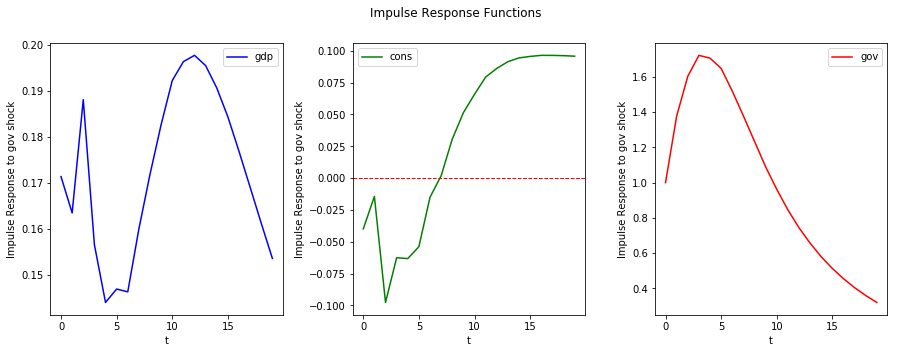

In [26]:
[df, covariates] = produce_lags(df.copy(), columns, lags)
[orig_reduced_form_coefficients, orig_reduced_form_residuals] = run_VAR(df, covariates, columns)
VCOV = np.cov(orig_reduced_form_residuals)
correlation = np.corrcoef(orig_reduced_form_residuals)
[A0_orig, A0_inv_orig, covariates, df] = get_A0(df, covariates, orig_reduced_form_residuals)
print(A0_orig)
orig_empty_array = tidy_IRF(columns, orig_reduced_form_coefficients,lags)
orig_Companion = create_companion(columns, lags, orig_empty_array)
forecast_horizon = 20
orig_IRF = create_IRF(impulse_var='gov', columns_input=columns, A0_inv = A0_inv_orig, forecast_horizon = forecast_horizon, Companion = orig_Companion)
create_IRF_plot(orig_IRF, columns, forecast_horizon, 'gov')

In [27]:
IRF_list = []

iterations = 100

for i in range(iterations):
    
    bs_df = pd.DataFrame(get_BS_TS(orig_empty_array, 
          df_original, 
          lags, columns, 
          orig_reduced_form_residuals, 
          orig_reduced_form_coefficients, 
          test = False, sig_u = None, burn = 100))
    [df, covariates] = produce_lags(bs_df.copy(), columns, lags)
    [reduced_form_coefficients, reduced_form_residuals] = run_VAR(df, covariates, columns)
    VCOV = np.cov(reduced_form_residuals)
    correlation = np.corrcoef(reduced_form_residuals)
    [A0, A0_inv, covariates, df] = get_A0(df, covariates, reduced_form_residuals)
    empty_array = tidy_IRF(columns, reduced_form_coefficients, lags)
    Companion = create_companion(columns, lags, empty_array)
    IRF = create_IRF(impulse_var='gov', columns_input=columns, A0_inv = A0_inv, forecast_horizon=20, Companion = Companion)
    #create_IRF_plot(IRF, columns, 20, 'gov')
    IRF_list.append(IRF)

In [28]:
split_list = []

for t in range(20):
    
    time_list = []
    
    for i in IRF_list:
        
        time_list.append(list(i[t]))
        
    split_list.append(time_list)

In [29]:
time_list = []

for i in range(len(columns)):
    
    var_list = []
    
    for j in range(len(split_list)):
    
        upper = np.percentile(np.array(split_list[j]).T[i], 97.5)
        lower = np.percentile(np.array(split_list[j]).T[i], 2.5)
    
        upper_lower = np.array([lower, upper])
    
        var_list.append(upper_lower)
    
    time_list.append(var_list)

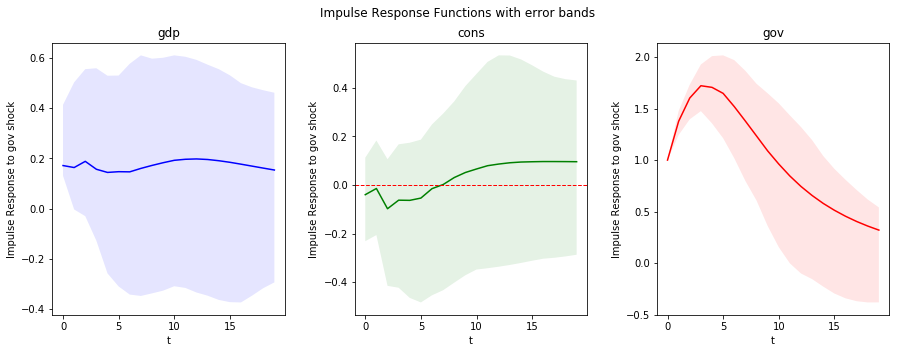

In [30]:
impulse_var = 'gov'
f, axarr = plt.subplots(1,len(columns), sharex=False, sharey=False)
f.suptitle('Impulse Response Functions with error bands')
x = range(orig_IRF.T[0].shape[0])
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
rcParams['figure.figsize'] = 15, 5

for color, i, idx in zip(colors, columns, range(len(columns))):
    
    axarr[idx].plot(x, orig_IRF.T[idx], color = color, label = i)
    axarr[idx].set(xlabel='t', ylabel= 'Impulse Response to ' + impulse_var + ' shock')
    axarr[idx].title.set_text(i)
    #axarr[idx].legend()
    axarr[idx].fill_between(x, np.array(time_list)[idx].T[0], np.array(time_list)[idx].T[1], alpha=0.1, edgecolor=None, facecolor=color)
    
    if (sum(orig_IRF.T[idx] > 0) > 0 and sum(orig_IRF.T[idx] < 0) > 0):
        
        axarr[idx].axhline(linewidth=1, color='r', linestyle = '--')
        
f.subplots_adjust(left = None, right = None, hspace=0, wspace = 0.3)

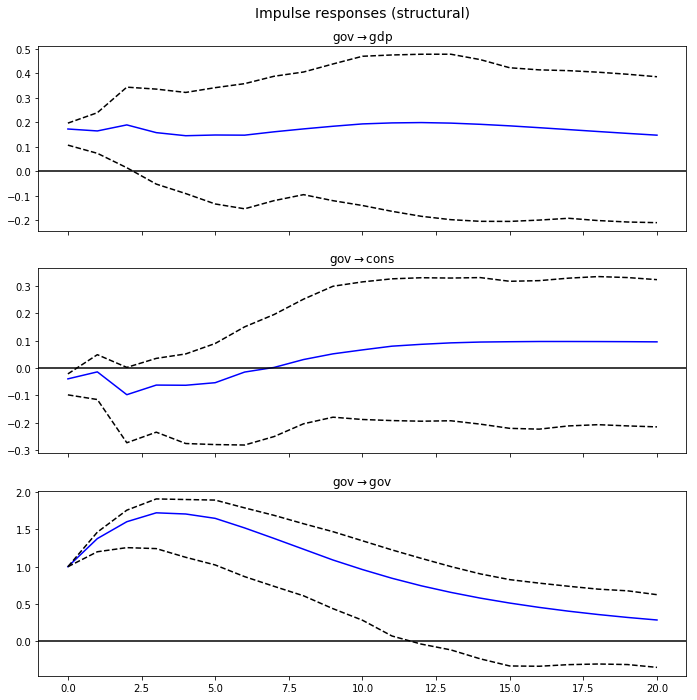

In [31]:
A = np.asarray([[1, 0, 'E'],[0, 1, 'E'],[0, 0, 1]])
original_model = SVAR(df_original[columns], svar_type='A', A=A)
original_result = original_model.fit(maxlags=lags, maxiter=10000, maxfun=10000, solver='bfgs', trend='ct')
orig_irf = original_result.irf(periods=20).plot(impulse='gov', plot_stderr=True, stderr_type = 'mc', repl=100)